In [1]:
import os
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import utils
from model.fc import *


/opt/conda/envs/apd-env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utils

In [2]:
def test_accuracy_by_category(model, testloader):
    correct = [0 for c in range(10)]
    total = [0 for c in range(10)]
    for i, data in enumerate(testloader, 0):
        test_inputs, test_labels = data
        test_inputs, test_labels = utils.cuda((test_inputs, test_labels), arguments)
        with torch.no_grad():
            test_inputs, test_labels = Variable(test_inputs), Variable(test_labels)
        preds = model.forward(test_inputs).argmax(axis=1)

        for c in range(10):
            correct[c] += sum((preds == test_labels) * (test_labels == c)).float()
            total[c] += sum(test_labels == c)

    acc = []
    for c in range(10):
        acc.append(correct[c].cpu().numpy() / total[c].cpu().numpy())
    
    return(acc)

In [3]:
# def ce_loss_by_category(model, testloader):
#     loss = nn.CrossEntropyLoss()
#     ce_list = []
#     for i, data in enumerate(mnist_testloader, 0):
#         test_inputs, test_labels = data
#         test_inputs, test_labels = utils.cuda((test_inputs, test_labels), arguments)
#         with torch.no_grad():
#             test_inputs, test_labels = Variable(test_inputs), Variable(test_labels)
#         preds = model.forward(test_inputs)
#         ce_list.append(loss(preds, test_labels).cpu().detach().numpy())
    
#     return(ce_list)

In [4]:
def svhn_test_accuracy_by_category(model, testloader):
    correct = [0 for c in range(10)]
    total = [0 for c in range(10)]
    for i, data in enumerate(testloader, 0):
        test_inputs, test_labels = data
        test_inputs, test_labels = utils.cuda((test_inputs, test_labels), arguments)
        test_inputs = torch.mean(test_inputs, 1)
        with torch.no_grad():
            test_inputs, test_labels = Variable(test_inputs), Variable(test_labels)
        preds = model.forward(test_inputs).argmax(axis=1)

        for c in range(10):
            correct[c] += sum((preds == test_labels) * (test_labels == c)).float()
            total[c] += sum(test_labels == c)

    acc = []
    for c in range(10):
        acc.append(correct[c].cpu().numpy() / total[c].cpu().numpy())
        
    return(acc)

### Get Test Data

In [5]:
batch_size = 100

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
#             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
svhn_transform = transforms.Compose([
    transforms.Scale(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
svhn_testset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=svhn_transform)
svhn_testloader = torch.utils.data.DataLoader(svhn_testset, batch_size=batch_size, shuffle=False, num_workers=2)


/opt/conda/envs/apd-env/lib/python3.6/site-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Using downloaded and verified file: ./data/test_32x32.mat


### SGLD

In [7]:
# MNIST
exp_name = 'fc1-mnist-100-X-sgld-mnist-1-1-X-mnist-50000@2022-12-17'

model_config = yaml.safe_load(open(os.path.join('saves', exp_name, 'fc1-mnist-100.yaml'), 'rb'))
model = eval(model_config['name'])(**model_config['kwargs'])
arguments = None
model = utils.cuda(model, arguments)

best_model_state_dict = torch.load(os.path.join('saves', exp_name, 'best_point_model.th'))
model.load_state_dict(best_model_state_dict)

sgld_mnist_accuracy = test_accuracy_by_category(model, mnist_testloader)

In [8]:
# SVHN
exp_name = 'fc1-svhn-100-X-sgld-svhn-1-1-X-svhn-50000@2022-12-19'

model_config = yaml.safe_load(open(os.path.join('saves', exp_name, 'fc1-svhn-100.yaml'), 'rb'))
model = eval(model_config['name'])(**model_config['kwargs'])
arguments = None
model = utils.cuda(model, arguments)

best_model_state_dict = torch.load(os.path.join('saves', exp_name, 'best_point_model.th'))
model.load_state_dict(best_model_state_dict)

sgld_svhn_accuracy = svhn_test_accuracy_by_category(model, svhn_testloader)

### APD

In [9]:
# MNIST
exp_name = 'mnist-wgan-gp-1000-100-5'
gan_mnist_accuracy = np.load(os.path.join('gan_exps', exp_name, 'gan_accuracy.npy'))
real_mnist_accuracy = np.load(os.path.join('gan_exps', exp_name, 'real_accuracy.npy'))

In [10]:
# SVHN
exp_name = 'svhn-wgan-gp-1000-100-5'
gan_svhn_accuracy = np.load(os.path.join('gan_exps', exp_name, 'gan_accuracy.npy'))
real_svhn_accuracy = np.load(os.path.join('gan_exps', exp_name, 'real_accuracy.npy'))

### MC Dropout

In [11]:
# MNIST
exp_name = 'fc1-mnist-100-drop-50-X-sgd-mnist-X-mnist-50000@2022-12-18'

model_config = yaml.safe_load(open(os.path.join('saves', exp_name, 'fc1-mnist-100-drop-50.yaml'), 'rb'))
model = eval(model_config['name'])(**model_config['kwargs'])
arguments = None
model = utils.cuda(model, arguments)

best_model_state_dict = torch.load(os.path.join('saves', exp_name, 'best_point_model.th'))
model.load_state_dict(best_model_state_dict)

mc_mnist_accuracy = test_accuracy_by_category(model, mnist_testloader)

In [12]:
# SVHN
exp_name = 'fc1-svhn-100-drop-50-X-sgd-svhn-X-svhn-50000@2022-12-19'

model_config = yaml.safe_load(open(os.path.join('saves', exp_name, 'fc1-svhn-100-drop-50.yaml'), 'rb'))
model = eval(model_config['name'])(**model_config['kwargs'])
arguments = None
model = utils.cuda(model, arguments)

best_model_state_dict = torch.load(os.path.join('saves', exp_name, 'best_point_model.th'))
model.load_state_dict(best_model_state_dict)

mc_svhn_accuracy = svhn_test_accuracy_by_category(model, svhn_testloader)

### Deterministic

In [13]:
mnist_df = pd.read_csv('saves/deterministic/MNIST.csv')

In [14]:
svhn_df = pd.read_csv('saves/deterministic/SVHN.csv')

## Plots

In [15]:
mnist_df['sgld_acc'] = sgld_mnist_accuracy
mnist_df['apd_acc'] = gan_mnist_accuracy
mnist_df['mc_acc'] = mc_mnist_accuracy

In [41]:
mnist_df

,teacher_loss,teacher_acc,student_kd_loss,student_kd_acc,student_no_kd_loss,student_no_kd_acc,sgld_acc,apd_acc,mc_acc
0,0.050336,0.9837,0.203816,0.9652,0.125644,0.9613,0.988571,0.985665,0.991633
1,0.037320,0.9873,0.140226,0.9724,0.102836,0.9714,0.987665,0.979181,0.990617
2,0.034810,0.9884,0.102437,0.9805,0.091386,0.9762,0.953488,0.949204,0.960233
3,0.034956,0.9884,0.102811,0.9795,0.098996,0.9762,0.956436,0.955318,0.965644
4,0.033665,0.9889,0.089748,0.9825,0.092973,0.9773,0.963340,0.959011,0.966212
5,0.032613,0.9907,0.073199,0.9842,0.106625,0.9775,0.950673,0.918127,0.958251
6,0.034780,0.9899,0.076513,0.9838,0.105950,0.9782,0.961378,0.956211,0.969729
7,0.030717,0.9905,0.089310,0.9824,0.111876,0.9777,0.965953,0.931081,0.972335
8,0.030025,0.9912,0.076228,0.9846,0.110385,0.9773,0.953799,0.945830,0.961478
9,0.034736,0.9920,0.075781,0.9839,0.111420,0.9811,0.922785,0.922234,0.937562


In [42]:
mnist_df.mean()

teacher_loss          0.035396
teacher_acc           0.989100
student_kd_loss       0.103007
student_kd_acc        0.979900
student_no_kd_loss    0.105809
student_no_kd_acc     0.975420
sgld_acc              0.960409
apd_acc               0.950186
mc_acc                0.967369
dtype: float64

In [45]:
(np.mean(mnist_df['teacher_acc']) - np.mean(mnist_df['student_kd_acc']))*100

0.9199999999999875

In [46]:
(np.mean(mnist_df['sgld_acc']) - np.mean(mnist_df['apd_acc']))* 100

1.0222664104616364

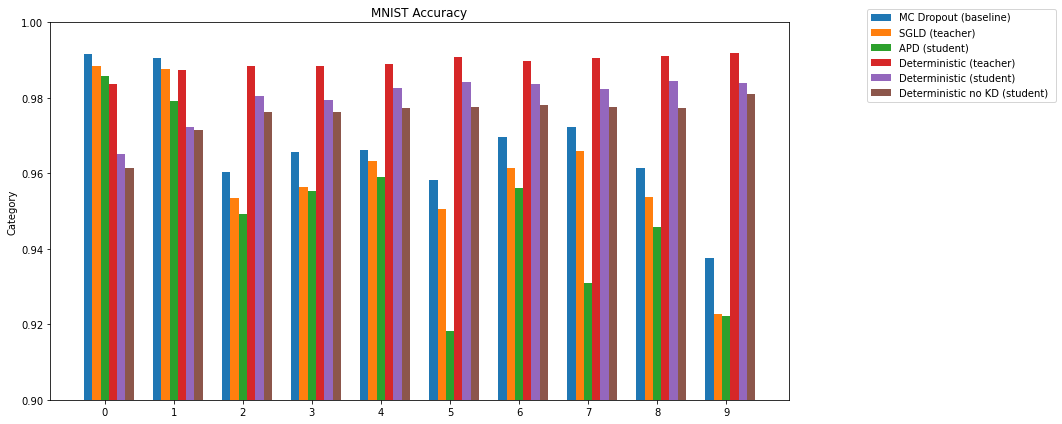

In [26]:
labels = ['0','1','2','3','4','5','6','7','8','9']

x = np.arange(10)
width = 0.12  # the width of the bars

fig = plt.figure(figsize=(15,6))
plt.bar(x - 2*width, mnist_df['mc_acc'], width, label='MC Dropout (baseline)')
plt.bar(x - width, mnist_df['sgld_acc'], width, label='SGLD (teacher)')
plt.bar(x, mnist_df['apd_acc'], width, label='APD (student)')
plt.bar(x + width, mnist_df['teacher_acc'], width, label='Deterministic (teacher)')
plt.bar(x + width*2, mnist_df['student_kd_acc'], width, label='Deterministic (student)')
plt.bar(x + width*3, mnist_df['student_no_kd_acc'], width, label='Deterministic no KD (student) ')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Accuracy')
plt.ylabel('Category')
plt.title('MNIST Accuracy')
plt.xticks(x)
plt.ylim([0.9, 1])
plt.legend(bbox_to_anchor=(1.1, 1.05))

fig.tight_layout()

plt.show()

In [27]:
svhn_df['sgld_acc'] = sgld_svhn_accuracy
svhn_df['apd_acc'] = gan_svhn_accuracy
svhn_df['mc_acc'] = mc_svhn_accuracy

In [47]:
svhn_df.mean()

teacher_loss          0.492893
teacher_acc           0.860433
student_kd_loss       1.872445
student_kd_acc        0.558574
student_no_kd_loss    2.020110
student_no_kd_acc     0.262696
sgld_acc              0.756214
apd_acc               0.423630
mc_acc                0.813047
dtype: float64

In [48]:
(np.mean(svhn_df['teacher_acc']) - np.mean(svhn_df['student_kd_acc']))*100

30.185925030000003

In [49]:
(np.mean(svhn_df['sgld_acc']) - np.mean(svhn_df['apd_acc']))* 100

33.258337210004015

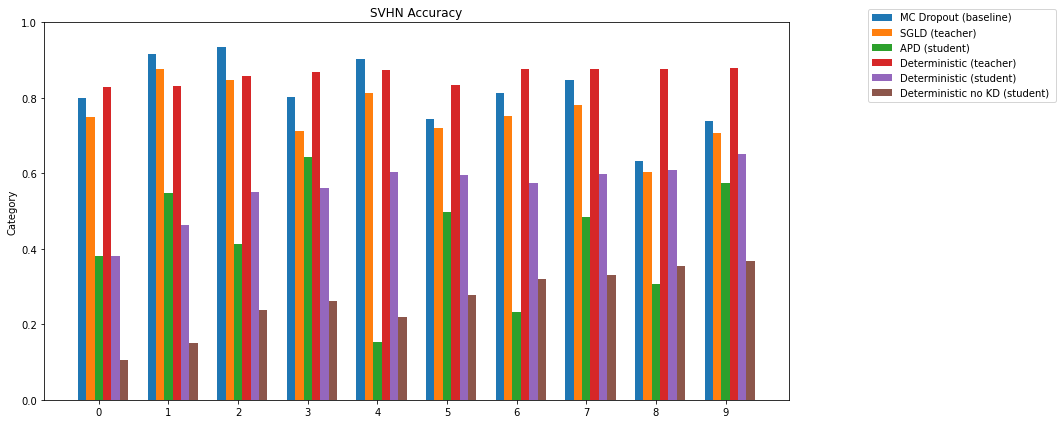

In [34]:
labels = ['0','1','2','3','4','5','6','7','8','9']

x = np.arange(10)
width = 0.12  # the width of the bars

fig = plt.figure(figsize=(15,6))
plt.bar(x - 2*width, svhn_df['mc_acc'], width, label='MC Dropout (baseline)')
plt.bar(x - width, svhn_df['sgld_acc'], width, label='SGLD (teacher)')
plt.bar(x, svhn_df['apd_acc'], width, label='APD (student)')
plt.bar(x + width, svhn_df['teacher_acc'], width, label='Deterministic (teacher)')
plt.bar(x + width*2, svhn_df['student_kd_acc'], width, label='Deterministic (student)')
plt.bar(x + width*3, svhn_df['student_no_kd_acc'], width, label='Deterministic no KD (student) ')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Accuracy')
plt.ylabel('Category')
plt.title('SVHN Accuracy')
plt.xticks(x)
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.1, 1.05))

fig.tight_layout()

plt.show()